In [1]:
import equinox as eqx
from jax import dtypes, vmap
import jax.numpy as jnp
import jax.random as random
from jpdenet.grad import egrad
from jpdenet.loss import ic_loss, bc_loss, MSE
from jpdenet.model import MLP
from jpdenet.train import create_batches
import matplotlib.pyplot as plt
import numpy as np
import optax
from typing import Tuple

# set random seed
PRNGKEY = random.PRNGKey(1)

# 1D problem
ndims = 1

In [2]:
# define model
model = MLP(PRNGKEY, (ndims + 1, 20, 20, 1))

In [3]:
# define loss function


def residual_loss(model, xb):
    """
    1D scalar advection equation
    """
    grads = egrad(vmap(model, in_axes=0))(xb)
    dudt = grads[:, 1]
    dudx = grads[:, 0]
    return MSE(dudt + dudx)


def u0(x):
    """
    initial square wave
    """
    return jnp.where(x < 0.25, 0.0, jnp.where(x > 0.75, 0.0, 1.0))


def loss(model, xb):
    """
    combines all three losses
    """
    out = residual_loss(model, xb)
    out += ic_loss(u0, model, xb)
    out += bc_loss(model, xb, mode="periodic")
    return out

In [4]:
# define function for training
def train(
    key: dtypes.prng_key,
    model: eqx.Module,
    optim: optax.GradientTransformation,
    x_train: jnp.ndarray,
    n_epochs: int,
    n_batches: int,
    print_every: int = -1,
) -> Tuple[eqx.Module, list]:
    """
    args:
        key: PRNG key
        model: neural network model
        optim: valid optax optimizer
        x_train: sample points in space where each column is the alue of the spatial coordinate. the last column is the time coordinate
        n_epochs: number of epochs
        n_batches: number of batches
        print_every: print loss every print_every epochs
    returns:
        model: trained model
        loss_values: list of loss values accumulated during training
    """
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def take_step(model, opt_state, xb):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, xb)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    loss_values = []
    for epoch in range(n_epochs):
        key, _ = random.split(key)
        for xb in create_batches(key, x_train, n_batches):
            model, opt_state, loss_value = take_step(model, opt_state, xb)
            loss_values.append(loss_value)
        if (epoch + 1) % print_every == 0:
            print(f"epoch {epoch + 1}, loss {loss_values[-1]}")

    return model, loss_values

In [5]:
# set hyperparameters
n_epochs = 20
n_batches = 100
print_every = 1
optim = optax.adam(1e-2)

# generate data
n_data = 10000
x_train = random.uniform(PRNGKEY, (n_data, ndims + 1))

In [6]:
model, loss_values = train(
    key=PRNGKEY,
    model=model,
    optim=optim,
    x_train=x_train,
    n_epochs=n_epochs,
    n_batches=n_batches,
    print_every=print_every,
)

epoch 1, loss 0.18234945833683014
epoch 2, loss 0.09505277127027512
epoch 3, loss 0.04381062835454941
epoch 4, loss 0.027376841753721237
epoch 5, loss 0.038181982934474945
epoch 6, loss 0.027112051844596863
epoch 7, loss 0.022123413160443306
epoch 8, loss 0.017411893233656883
epoch 9, loss 0.02036082185804844
epoch 10, loss 0.0237612035125494
epoch 11, loss 0.014726501889526844
epoch 12, loss 0.017754515632987022
epoch 13, loss 0.009106360375881195
epoch 14, loss 0.015217610634863377
epoch 15, loss 0.017412450164556503
epoch 16, loss 0.014052697457373142
epoch 17, loss 0.018724137917160988
epoch 18, loss 0.021764809265732765
epoch 19, loss 0.01481353584676981
epoch 20, loss 0.006973689887672663


Text(0, 0.5, 'loss')

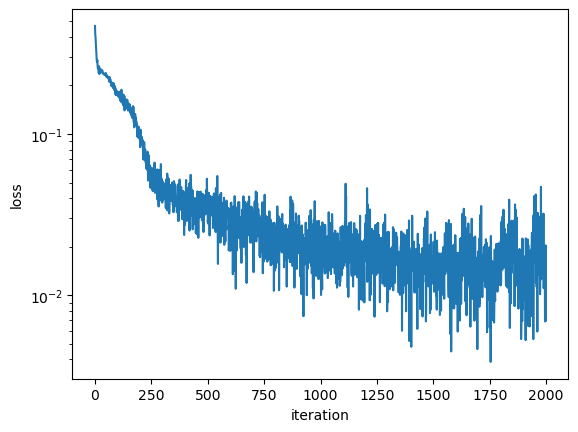

In [7]:
plt.plot(loss_values)
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("loss")

Text(0.5, 0, 'x')

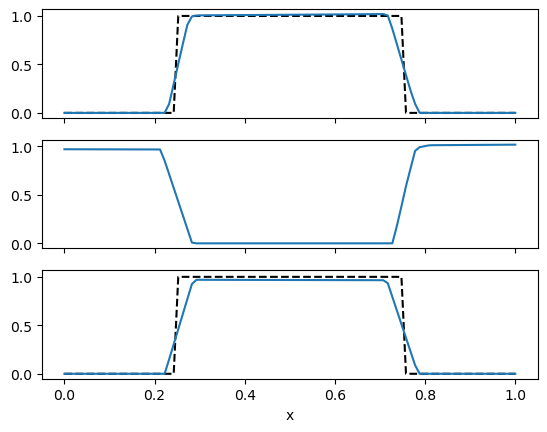

In [8]:
fix, axs = plt.subplots(3, sharex=True, sharey=True)

# plotting mesh
N = 100
x = np.linspace(0, 1, N)


def model_viewer(model, x, t: float = 0.0, N: int = 100):
    X = np.empty((N, 2))
    X[:, 0] = x
    X[:, 1] = t
    return vmap(model, in_axes=0)(X)


axs[0].plot(x, u0(x), color="k", linestyle="--")
axs[0].plot(x, model_viewer(model, x, t=0.0, N=N))
axs[1].plot(x, model_viewer(model, x, t=0.5, N=N))
axs[2].plot(x, u0(x), color="k", linestyle="--")
axs[2].plot(x, model_viewer(model, x, t=1.0, N=N))
axs[2].set_xlabel("x")